In [1]:
import numpy as np
%matplotlib inline

単語の分散表現を得るため，前章ではカウントベースの手法を実装したのに対し，本章では推論ベースの手法であるWord2Vecを実装する．

# まとめ
word2vecのCBOWモデルと呼ばれるNNについて詳しく説明し，実装を行なった．  
- 推論ベースの手法
    - コンテキスト，ターゲット間の関係を推論する問題を通して，その副産物として単語の分散表現（ベクトル表現）を得る
    - 単語が追加された時，1から計算をやり直さなくてはならないカウントベースの手法と比べ，それまでの重みを初期値として利用できる点で効率的．
    - word2vec
        - 基本的には2層のNN
        - MatMulレイヤとSoftmaxWithLossレイヤによる分類問題として構成されるモデル
        - 小さなコーパスでも学習はできる．
        - 現状では処理効率がよくない．  
        - CBOWモデル
            - コンテキストからターゲットを推論する問題
        - skip-gram モデル
            - ターゲットからコンテキストを推論する問題


# 推論ベースの手法とニューラルネットワーク
カウントベースの手法も推論ベースの手法も分布仮説に基づいている．

## カウントベースの手法の問題点
カウントベースの手法は大規模なコーパスでは扱いが難しい．  
100万単語を扱うなら，100万×100万の行列を作り，それに対して$O(n^3)$のSVDを行う必要があり，現実的でない．  
一方で，推論ベースの手法はミニバッチによる逐次的な学習が可能であり，GPUによる並列計算も可能である．

## 推論ベースの手法の概要
推論ベースの手法では，「you ? goodbye and I say hello」の?にあたる単語を推測する問題を解き，学習する．  
you,goodbyeというコンテキストをモデルに渡して学習させると，? の部分に入る単語の確率分布を得る，といった形になる．  
その結果が単語の分散表現になる．  
そして今回，そのモデルには，ニューラルネットワークを用いる．  
カウントベースの手法も，推論ベースの手法も，「単語の共起性」をいかにモデル化するかが重要な研究テーマになっている．

## ニューラルネットワークにおける単語の処理方法
NNでは単語をone-hotベクトルに変換して取り扱う．  
one-hotベクトルは，語彙数を$n$とすると，$n$次元ベクトルで表され，値が1である1つの要素を除き全てが0のベクトルである．  
こうすることで，NNの入力層はニューロンの数を$n$に固定できる．  
なお，本章で使用する全結合層では，バイアスを省略する．(MatMulレイヤに相当)  

例えば，入力が7次元，中間層が3次元なら，重み行列は7×3になり，以下のようなコードになる．

In [2]:
c = np.array([[1,0,0,0,0,0,0]]) # ミニバッチ処理を考慮して2次元になっている．
W = np.random.randn(7, 3)
h = c @ W
print(h)

# Matmulレイヤによる計算
from common.layers import MatMul
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[-0.07880115  0.63280227 -1.99906065]]
[[-0.07880115  0.63280227 -1.99906065]]


cはone-hotベクトルであるため，Wの1行目を抜き出してhとしていることとなる．  
この非効率性の改良は次章で行う．  

# シンプルなword2vec
コンテキストから単語の分散表現を得るために用いるモデルの部分に，NNを組み込みたい．  
そのNNとして，continuous bag-of-words (CBOW)というものを用いる方法を説明する．  

word2vecは本来プログラムやツール類のことを指すが，今の文脈ではNNのモデルを指す．  
正しくは，このCBOWモデルと，skip-gramモデル(3.5.3)のいずれかを指す模様．

## CBOWモデルの推論処理
コンテキスト(周囲の単語)からターゲット(中央の単語)を推測することを目的としたNN．  
CBOWモデルへの入力はコンテキスト  

コンテキストとなる単語が2つあるなら，入力層は2つになり，中間層と出力層によってCBOWモデルはなる．  
入力層から中間層への重みをWin, 中間層から出力層への重みをWoutと呼ぶ．  

中間層の出力は各入力層の全結合による変換後の値が平均されたものになる．  
1つ目の入力層がh1，2つ目の入力層がh2に変換されたとすると，中間層のニューロンは$\frac{1}{2} (h_1 + h_2)$となる．  

出力層では各単語のスコアを算出し，Softmax関数を適用することでその単語がターゲットに当てはまる確率を求められる．  
ここでは，Softmaxに通す前のノードを出力層と呼ぶことにする．  

Winの部分の重みが単語の分散表現になり，Winでは「単語の意味」もうまくエンコードされている．  

ここでポイントとなるのは，中間層のニューロンの数を入力層のものよりも減らすことにある．  
中間層では，単語を予測するために必要な情報をコンパクトに収め，密なベクトル表現を得る．  

中間層の情報は我々には理解できない「コード」で書かれている．  
学習して，中間層の情報にすることをエンコード，逆にその情報から目的の結果を得ることをデコードという．  

計算グラフでCBOWモデルを表すと，
- 2つの入力ベクトルをWinを持つMatMulレイヤに通す．
- その2つの入力を加算レイヤに渡し，和を得る．
- それに0.5をかける乗算レイヤを通す．
- それをWoutを持つMatMulレイヤに通す．
- scoreを得る．

CBOWモデルの推論処理をPythonで実装してみる．

In [3]:
from common.layers import MatMul

c0 = ([[1,0,0,0,0,0,0]])
c1 = ([[0,0,1,0,0,0,0]])

W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[ 0.12576574 -0.25113191  0.14258779 -0.11432049 -0.01785427  0.46932842
  -0.11032777]]


## CBOWモデルの学習
CBOWモデルやskip-gramモデルによって得られる単語の分散表現は，特にWikipediaなどの大規模コーパスを使うと，意味的にも文法的にも我々の直感と合致するケースが多い．  

CBOWモデルは，単語の出現パターンを学ぶだけなので，コーパスが違えば学習で得られる単語の分散表現も異なる．  
例えば，スポーツの記事だけを扱う場合と，音楽の記事だけを扱う場合には，得られる単語の分散表現は異なる．  

学習は単純に多クラス分類を行うNNを構築すればよい．  
出力をSoftmax関数に渡し，教師ラベルとの交差エントロピー誤差を求め，それを損失として逆伝播し，学習させる．  
このとき，SoftMaxWithLossレイヤを用いればよい．  

単語の分散表現としては，Winのみを使うのがポピュラーなやり方．  

文献38: Tying Word Vectors and Word Classifiers: A Loss Framework for Language Modelingでは，Winのみを使うことの有効性が示されている．  
文献27: Glove: Global Vectors for Word Representation で示されているword2vecに似た手法では，WinとWoutの和が有効であると報告されている．  

# 学習データの準備
You say goodbye and I say hello という1文をコーパスとして用いる．  

## コンテキストとターゲット
我々が行うべきことは，コンテキストとなる単語集合をNNに入力した時に，ターゲットの単語が出現する確率を高めること．  
コーパスから，両端を除いた単語をターゲット，それらの左右の1単語2つをコンテキストとして抜き出し，学習データとする．  

これから，コーパスからコンテキストとターゲットを作成する関数を実装する．

まずは2章で実装したpreprocess関数を使って，文章から単語IDによるコーパスと単語ID間辞書を生成する．  

In [4]:
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


次に，コーパスからコンテキストとターゲットを作成する関数を作成

In [5]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size+1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
    
    return np.array(contexts), np.array(target)

In [6]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)

print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


## one-hot表現への変換
コンテキストとターゲットをone-hot表現に変換する．  

In [7]:
from common.util import convert_one_hot

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
context = convert_one_hot(contexts, vocab_size)

print(target)
print()
print(context)

[[0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0]]

[[[1 0 0 0 0 0 0]
  [0 0 1 0 0 0 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 1 0 0 0]]

 [[0 0 1 0 0 0 0]
  [0 0 0 0 1 0 0]]

 [[0 0 0 1 0 0 0]
  [0 1 0 0 0 0 0]]

 [[0 0 0 0 1 0 0]
  [0 0 0 0 0 1 0]]

 [[0 1 0 0 0 0 0]
  [0 0 0 0 0 0 1]]]


# CBOWモデルの実装

In [8]:
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # レイヤの生成
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 全ての重みと勾配をリストにまとめる
        layers = [
            self.in_layer0,
            self.in_layer1,
            self.out_layer
        ]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
        
        # メンバ変数に単語の分散表現を設定
        self.word_vecs = W_in
    
    # contexts: 3次元のNumPy配列，ミニバッチ：コンテキスト：one-hotベクトル
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

ここでは，同じ重みW_inを複数のレイヤ，0,1で共有している．  
そのため，同じ重みがparams配列に存在してしまい，AdamやOptimizerの処理が本来の挙動と異なってしまう．  
そこで，Trainerクラスの内部では，パラメータの更新時にパラメータの重複を取り除くremove_duplicate関数が利用されている．

## 学習コードの実装
通常のNNの学習と全く同じ．  
- 学習データを準備
- 学習データをNNに与える
- 勾配降下法と誤差逆伝播による重みパラメータのアップデートを繰り返す
- アップデートしながら精度を確認していく

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 210 |  iter 1 / 2 | time 0[s] | loss 1.24
| epoch 211 |  iter 1 / 2 | time 0[s] | loss 1.29
| epoch 212 |  iter 1 / 2 | time 0[s] | loss 1.07
| epoch 213 |  iter 1 / 2 | time 0[s] | loss 1.32
| epoch 214 |  iter 1 / 2 | time 0[s] | loss 1.21
| epoch 215 |  iter 1 / 2 | time 0[s] | loss 1.29
| epoch 216 |  iter 1 / 2 | time 0[s] | loss 1.07
| epoch 217 |  iter 1 / 2 | time 0[s] | loss 1.29
| epoch 218 |  iter 1 / 2 | time 0[s] | loss 1.22
| epoch 219 |  iter 1 / 2 | time 0[s] | loss 1.21
| epoch 220 |  iter 1 / 2 | time 0[s] | loss 1.20
| epoch 221 |  iter 1 / 2 | time 0[s] | loss 1.27
| epoch 222 |  iter 1 / 2 | time 0[s] | loss 1.12
| epoch 223 |  iter 1 / 2 | time 0[s] | loss 1.20
| epoch 224 |  iter 1 / 2 | time 0[s] | loss 1.18
| epoch 225 |  iter 1 / 2 | time 0[s] | loss 1.18
| epoch 226 |  iter 1 / 2 | time 0[s] | loss 1.21
| epoch 227 |  iter 1 / 2 | time 0[s] | loss 1.09
| epoch 228 |  iter 1 / 2 | time 0[s] | loss 1.25
| epoch 229 |  iter 1 / 2 | time 0[s] | loss 1.20


| epoch 377 |  iter 1 / 2 | time 0[s] | loss 0.97
| epoch 378 |  iter 1 / 2 | time 0[s] | loss 0.97
| epoch 379 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 380 |  iter 1 / 2 | time 0[s] | loss 0.83
| epoch 381 |  iter 1 / 2 | time 0[s] | loss 1.20
| epoch 382 |  iter 1 / 2 | time 0[s] | loss 0.99
| epoch 383 |  iter 1 / 2 | time 0[s] | loss 0.83
| epoch 384 |  iter 1 / 2 | time 0[s] | loss 1.09
| epoch 385 |  iter 1 / 2 | time 0[s] | loss 0.86
| epoch 386 |  iter 1 / 2 | time 0[s] | loss 1.09
| epoch 387 |  iter 1 / 2 | time 0[s] | loss 0.82
| epoch 388 |  iter 1 / 2 | time 0[s] | loss 1.11
| epoch 389 |  iter 1 / 2 | time 0[s] | loss 0.95
| epoch 390 |  iter 1 / 2 | time 0[s] | loss 0.86
| epoch 391 |  iter 1 / 2 | time 0[s] | loss 0.95
| epoch 392 |  iter 1 / 2 | time 0[s] | loss 0.86
| epoch 393 |  iter 1 / 2 | time 0[s] | loss 1.09
| epoch 394 |  iter 1 / 2 | time 0[s] | loss 0.85
| epoch 395 |  iter 1 / 2 | time 0[s] | loss 1.20
| epoch 396 |  iter 1 / 2 | time 0[s] | loss 0.71


| epoch 551 |  iter 1 / 2 | time 0[s] | loss 0.77
| epoch 552 |  iter 1 / 2 | time 0[s] | loss 1.15
| epoch 553 |  iter 1 / 2 | time 0[s] | loss 0.77
| epoch 554 |  iter 1 / 2 | time 0[s] | loss 0.92
| epoch 555 |  iter 1 / 2 | time 0[s] | loss 0.90
| epoch 556 |  iter 1 / 2 | time 0[s] | loss 0.90
| epoch 557 |  iter 1 / 2 | time 0[s] | loss 0.88
| epoch 558 |  iter 1 / 2 | time 0[s] | loss 0.81
| epoch 559 |  iter 1 / 2 | time 0[s] | loss 1.01
| epoch 560 |  iter 1 / 2 | time 0[s] | loss 0.92
| epoch 561 |  iter 1 / 2 | time 0[s] | loss 0.88
| epoch 562 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 563 |  iter 1 / 2 | time 0[s] | loss 1.03
| epoch 564 |  iter 1 / 2 | time 0[s] | loss 0.88
| epoch 565 |  iter 1 / 2 | time 0[s] | loss 1.03
| epoch 566 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 567 |  iter 1 / 2 | time 0[s] | loss 1.01
| epoch 568 |  iter 1 / 2 | time 0[s] | loss 0.88
| epoch 569 |  iter 1 / 2 | time 0[s] | loss 0.92
| epoch 570 |  iter 1 / 2 | time 0[s] | loss 0.78


| epoch 779 |  iter 1 / 2 | time 0[s] | loss 0.95
| epoch 780 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 781 |  iter 1 / 2 | time 0[s] | loss 0.82
| epoch 782 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 783 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 784 |  iter 1 / 2 | time 0[s] | loss 0.92
| epoch 785 |  iter 1 / 2 | time 0[s] | loss 0.83
| epoch 786 |  iter 1 / 2 | time 0[s] | loss 0.82
| epoch 787 |  iter 1 / 2 | time 0[s] | loss 0.80
| epoch 788 |  iter 1 / 2 | time 0[s] | loss 0.70
| epoch 789 |  iter 1 / 2 | time 0[s] | loss 0.93
| epoch 790 |  iter 1 / 2 | time 0[s] | loss 0.81
| epoch 791 |  iter 1 / 2 | time 0[s] | loss 0.70
| epoch 792 |  iter 1 / 2 | time 0[s] | loss 0.94
| epoch 793 |  iter 1 / 2 | time 0[s] | loss 0.81
| epoch 794 |  iter 1 / 2 | time 0[s] | loss 0.81
| epoch 795 |  iter 1 / 2 | time 0[s] | loss 0.80
| epoch 796 |  iter 1 / 2 | time 0[s] | loss 0.70
| epoch 797 |  iter 1 / 2 | time 0[s] | loss 1.05
| epoch 798 |  iter 1 / 2 | time 0[s] | loss 0.68


| epoch 950 |  iter 1 / 2 | time 0[s] | loss 0.66
| epoch 951 |  iter 1 / 2 | time 0[s] | loss 0.64
| epoch 952 |  iter 1 / 2 | time 0[s] | loss 0.81
| epoch 953 |  iter 1 / 2 | time 0[s] | loss 0.70
| epoch 954 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 955 |  iter 1 / 2 | time 0[s] | loss 0.76
| epoch 956 |  iter 1 / 2 | time 0[s] | loss 0.63
| epoch 957 |  iter 1 / 2 | time 0[s] | loss 0.81
| epoch 958 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 959 |  iter 1 / 2 | time 0[s] | loss 0.70
| epoch 960 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 961 |  iter 1 / 2 | time 0[s] | loss 0.80
| epoch 962 |  iter 1 / 2 | time 0[s] | loss 0.64
| epoch 963 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 964 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 965 |  iter 1 / 2 | time 0[s] | loss 0.69
| epoch 966 |  iter 1 / 2 | time 0[s] | loss 0.64
| epoch 967 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 968 |  iter 1 / 2 | time 0[s] | loss 0.63
| epoch 969 |  iter 1 / 2 | time 0[s] | loss 0.68


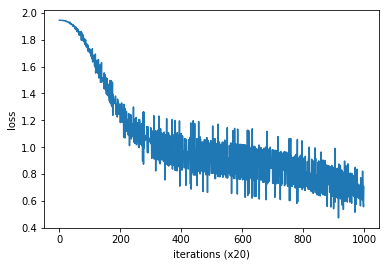

In [9]:
from common.trainer import Trainer
from common.optimizer import Adam

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

求める単語の分散表現は以下のようになる

In [10]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 0.94134265 -1.5670972   1.0042657  -0.9798423   1.0165973 ]
say [-1.1678194 -1.3449364 -0.9423725  1.127167  -1.1367421]
goodbye [ 0.96401954 -0.23867942  0.8721969  -0.96921825  0.8614409 ]
and [-0.26617897 -1.3233804  -1.8540628   0.81534934 -0.7823937 ]
i [ 0.93425214 -0.23797344  0.8558789  -0.9288582   0.84120965]
hello [ 0.95631564 -1.5801703   1.0058844  -0.9644152   1.0187151 ]
. [-1.5799508 -0.9287598  0.8394477  1.1933532 -1.2130911]


# word2vecに関する補足
word2vecを確率の視点で定式化

## CBOWモデルと確率
コンテキストとして$w_{t-1}とw_{t+1}$が与えられるとすると，ターゲットの単語が$w_t$になる確率は事後確率の形で，
$$ P(w_t | w_{t-1}, w_{t+1}) $$
と表現できる．  

これを交差エントロピー誤差の式
$$ L=-\sum_{k}t_k log{y_k} $$
に当てはめると，教師ラベル$t_k$は$k=t$のときのみ1のone-hotベクトルの要素なので，  
$$ L=-log{P(w_t | w_{t-1}, w_{t+1})}$$
と，シグマのない形に書き直せる．  
この式は**負の対数尤度**と呼ばれる．  

さらに，負の対数尤度の式をコーパス全体に拡張し，コーパス内の全単語の誤差の平均，すなわちCBOWの最小化対象となる目的関数は  
$$ L=-\frac{1}{T} \sum_{t=1}^{T} log{P(w_t | w_{t-1}, w_{t+1})}$$
となる．  

これはウィンドウサイズが1の場合の目的関数だが，$m$などの他のウィンドウサイズの場合も簡単に表せる．

## skip-gramモデル
CBOWモデルとは逆に，ターゲットからコンテキストを推測する．  
そのネットワーク構成は，入力層が一つ，出力層が複数になる．  

このとき，skip-gramのモデルは以下のようになる．  
$$ P(w_{t-1}, w_{t+1} | w_t) $$

ここで，skip-gramモデルでは，コンテキストの単語間に関連性がないと仮定(条件付き独立)すると，
$$ P(w_{t-1}, w_{t+1} | w_t) = P(w_{t-1} | w_t)P(w_{t+1} | w_t) $$
のように変形することができる．  

そしてこの式を交差エントロピー誤差に適用すると，
$$ L=-log{P(w_{t-1}, w_{t+1} | w_t)}$$
$$ = -log{P(w_{t-1} | w_t)P(w_{t+1} | w_t)} $$
$$ = -(log{P(w_{t-1} | w_t)} + log{P(w_{t+1} | w_t)}) $$
と変形できる．つまり，skip-gramの損失関数はコンテキストごとの損失の総和になる．  

さらにこれをコーパス全体に拡張すると，skip-gramの最小化対象となる目的関数は，
$$ L=-\frac{1}{T} \sum_{t=1}^{T} (log{P(w_{t-1} | w_t)} + log{P(w_{t+1} | w_t)})$$
となる．

CBOWとskip-gram，どちらを使うべきか？  
skip-gram: 単語の分散表現の精度が高いことが多い(CBOWより問題の難易度が難しいから？)  
CBOW: skip-gramはコンテキストの数だけ損失を求めるため，CBOWの方が比較的高速  

実装はch3/simple_skip_gram.pyにある．

## カウントベース vs 推論ベース
カウントベース(共起行列＋SVD)：　コーパス全体の統計データから1回の学習で単語の分散表現を獲得  
推論ベース(CBOW, skip-gramをNNで学習) : コーパスの一部を何度も見ながら学習し，NNの重みを単語の分散表現として獲得

- 語彙に新しい単語を追加する場合  
カウントベース: 共起行列を作り直し，SVDをもう一度行わなくてはならない  
推論ベース： これまでに学習した重みを初期値として再学習すればいい  
  
  
- 分散表現の性質  
カウントベース： 単語の類似性がエンコードされる  
推論ベース： 特にskip-gramで，単語間のパターンを捉えられる(king - man + woman = queen)のような類推問題を解ける  
  
  
- 精度
精度の定量的評価については優劣がつけられないことが報告されている．  
「Don't count, predict!」という論文もあれば，単語の類似性に関するタスクではハイパーパラメータの依存度が大きく，優劣がつけられないという報告もある．  

skip-gramとNegative Sampling(次章)を利用したモデルは，コーパス全体の共起行列に少し手を加えた行列に対して，特殊は行列分解をしているのと同じであることが示されており，ある条件において推論ベースの手法とカウントベースの手法は繋がっていることがわかっている．  

推論ベースとカウントベースの手法を融合させたようなGloVeという手法も提案されている．  
具体的には，コーパス全体の統計データの情報を損失関数に取り入れ，ミニバッチ学習をしている．